<font size="+3"><strong> COVID-19 Detection from Chest X-rays</strong></font>

## Abstract
This project implements a Convolutional Neural Network (CNN) to classify Chest X-ray images into three categories: **COVID-19**, **Normal**, and **Viral Pneumonia**. Using a dataset of 224x224 images, the model achieves automated diagnosis to assist in rapid clinical screening.


## Introduction
Early detection of COVID-19 via radiology is vital for patient triaging. This notebook follows a standard Computer Vision pipeline:
1. Data Preprocessing & Augmentation
2. Architectural Design (CNN)
3. Training & Validation
4. Performance Evaluation

### 1. Importing necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

import random
import os
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten
from keras.layers import Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

## 2. Dataset Overview

The dataset consists of Chest X-ray images categorized into three classes:
- **COVID-19:** X-rays of patients diagnosed with COVID-19.
- **Normal:** X-rays of healthy individuals.
- **Pneumonia:** X-rays of patients with other forms of pneumonia (e.g., bacterial, viral). This class is vital for differential diagnosis.

The dataset is structured into `train`, `val` (validation), and `test` directories.

### 2.1 Data Analysis

In [ ]:
df = pd.read_csv("shai_dataset/train.csv")  # Replace with actual file name
df.head()

,Image,Label
0,597631776.jpeg,normal
1,35266064.jpeg,virus
2,467414642.jpeg,normal
3,35667640.jpeg,normal
4,618841263.jpeg,normal


In [ ]:
df.describe()

,Image,Label
count,1196,1196
unique,1196,3
top,327147141.jpeg,normal
freq,1,468


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   1196 non-null   object
 1   Label   1196 non-null   object
dtypes: object(2)
memory usage: 18.8+ KB


In [ ]:
df['Label'].value_counts()

,count
Label,
normal,468
virus,433
covid,295


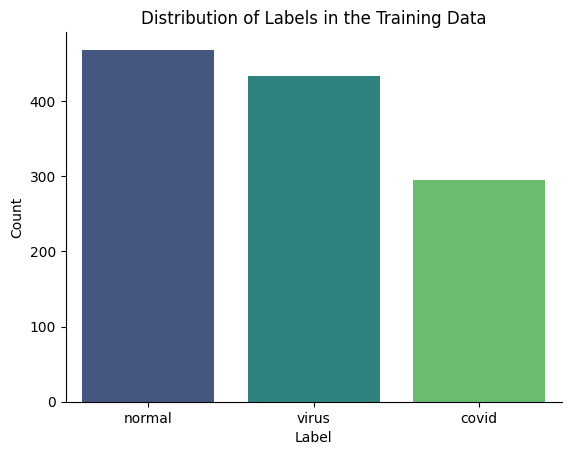

In [ ]:
countplot = sns.countplot(x='Label', data=df, palette='viridis')

plt.title('Distribution of Labels in the Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
sns.despine()
plt.show()

### 2.2. Sample Image Visualization

Let's visualize a few sample images from each class to understand the data.

In [ ]:
covid_path = "/content/shai_dataset/train/covid/"
normal_path = "/content/shai_dataset/train/normal/"
virus_path = "/content/shai_dataset/train/virus/"

def plotXRAY(url, rowsCount, colsCount, title):
    data = os.listdir(url)
    fig, ax = plt.subplots(rowsCount, colsCount, figsize=(15,15))


    fig.suptitle(title, fontsize=20)

    for row in range(rowsCount):
        for col in range(colsCount):
            img = plt.imread(url + data[row])
            ax[row, col].imshow(img, cmap="gray")


            ax[row, col].axis('off')


    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    plt.show()

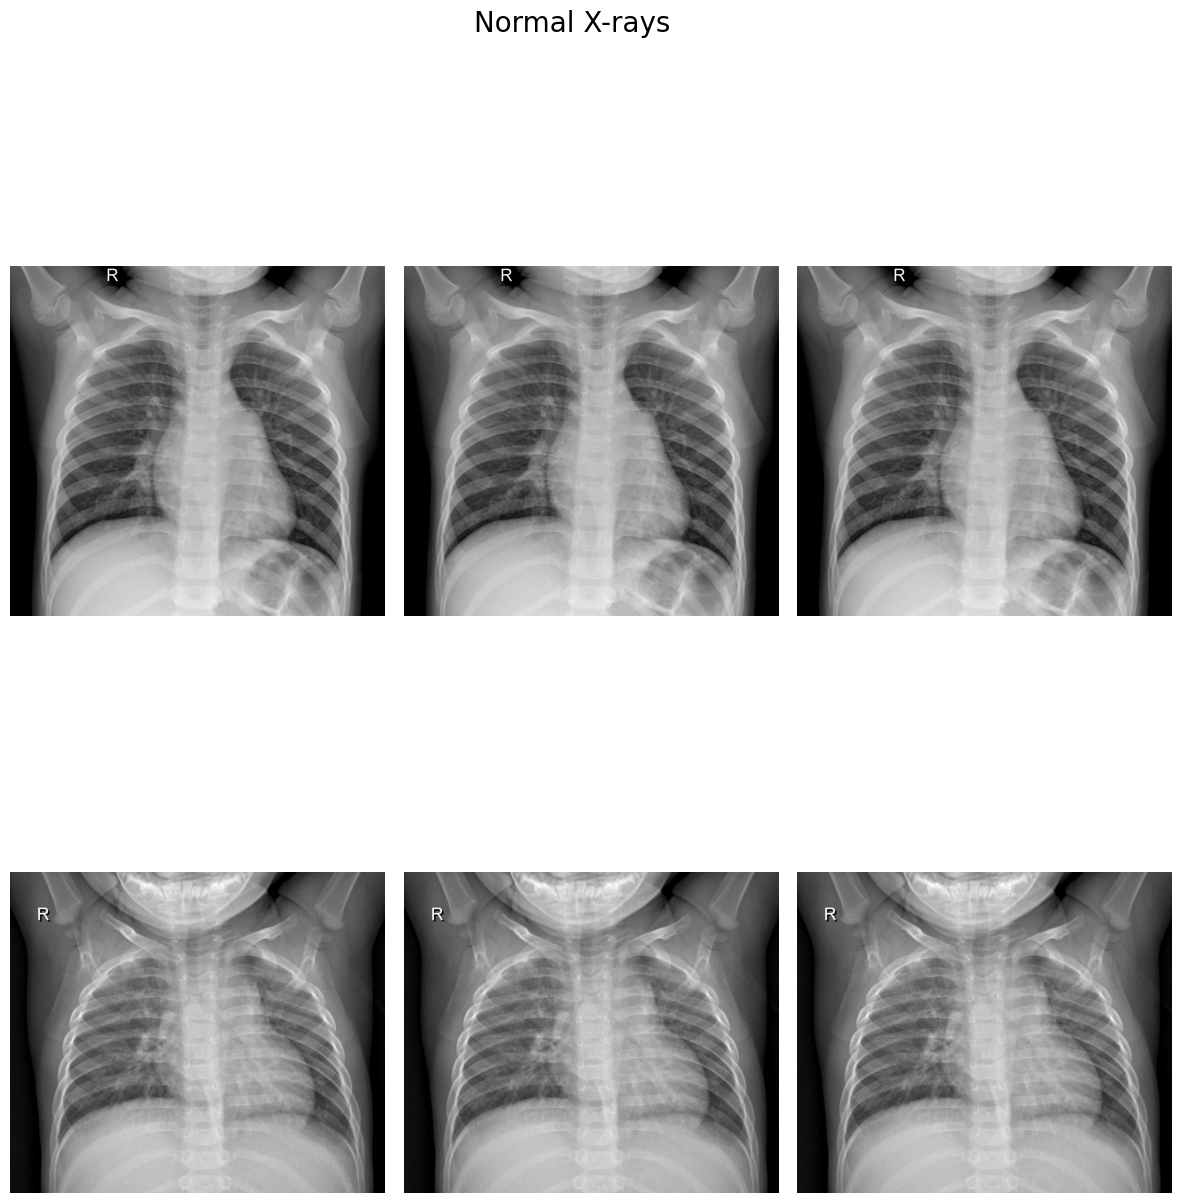

In [ ]:
plotXRAY(normal_path, 2, 3, "Normal X-rays")

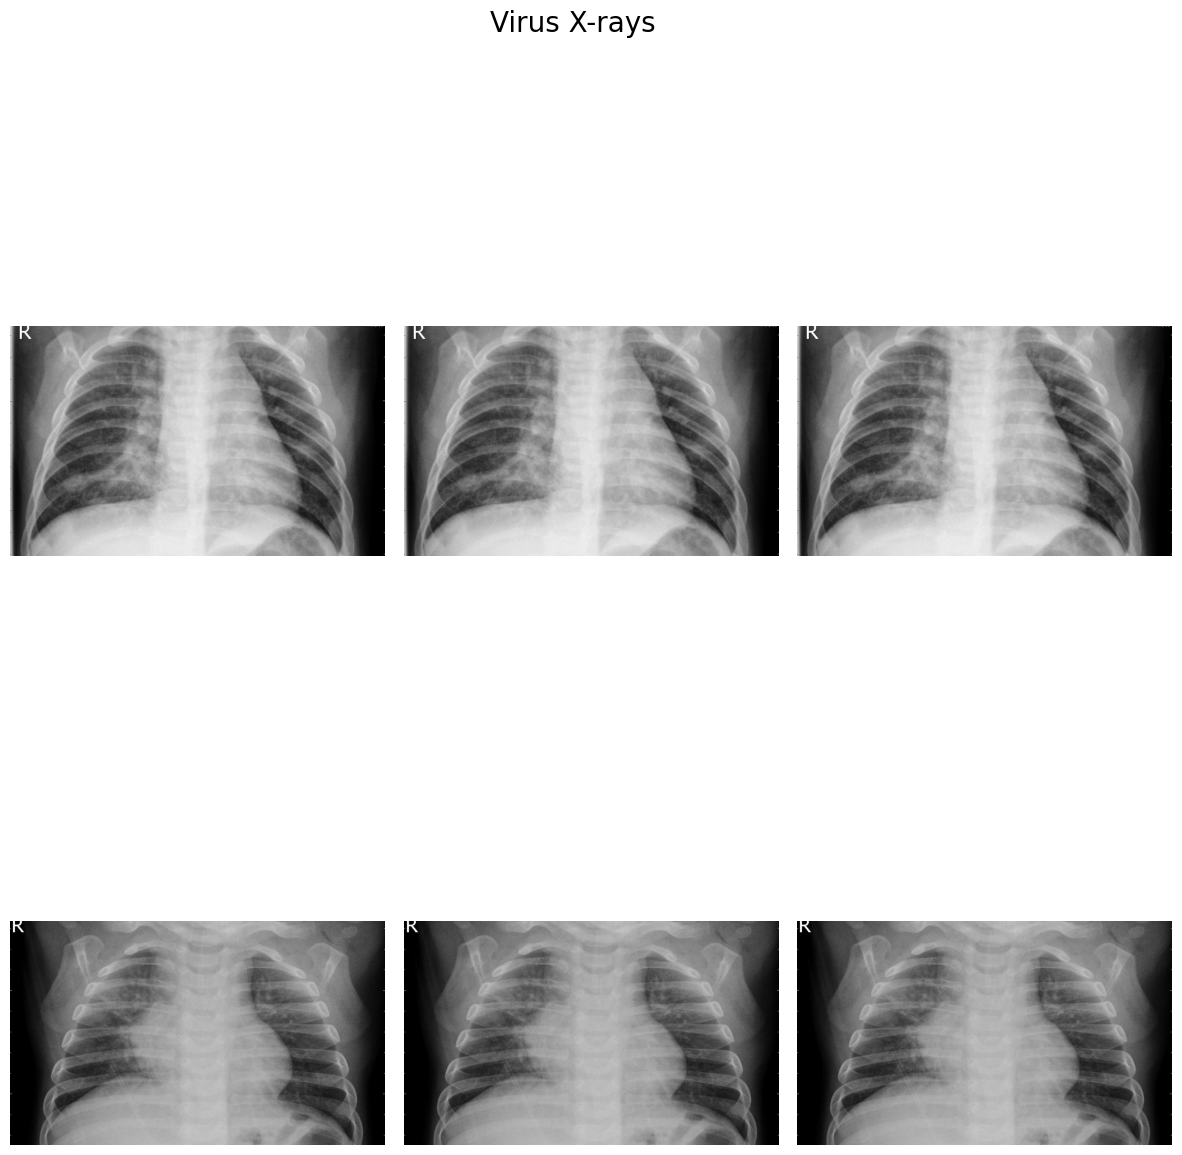

In [ ]:
plotXRAY(virus_path, 2, 3, "Virus X-rays")

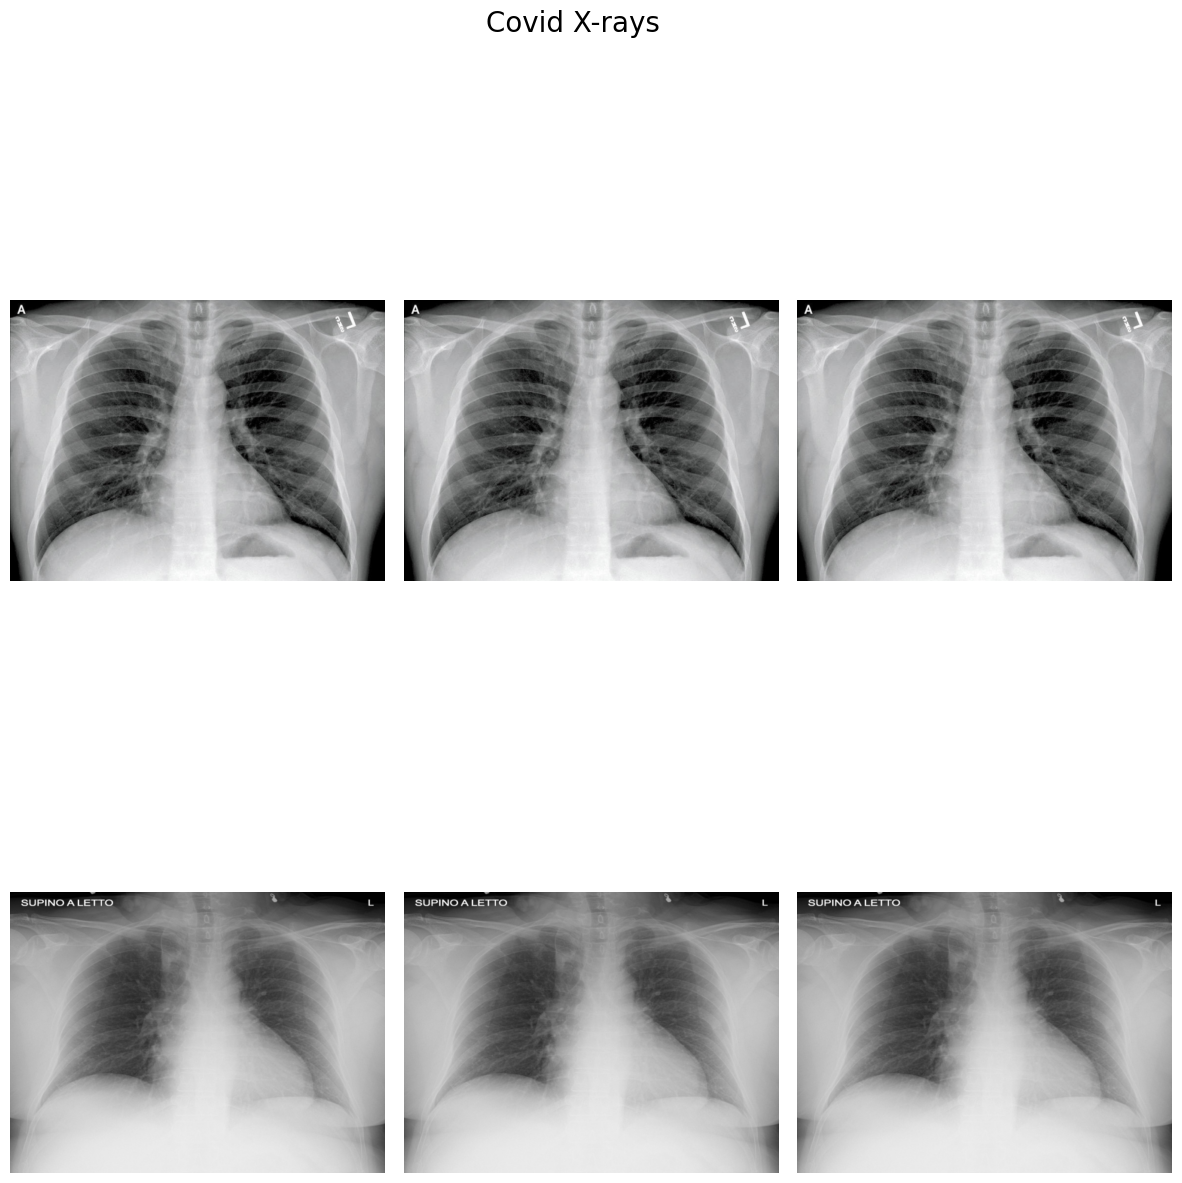

In [ ]:
plotXRAY(covid_path, 2, 3, "Covid X-rays")

## 3. Data Preprocessing and Augmentation


To prepare the images for the CNN, we use `ImageDataGenerator`. This allows for on-the-fly image loading, resizing, and normalization.

Crucially, we apply **Data Augmentation** to the training set. This technique artificially expands the dataset by applying random transformations (e.g., rotation, zoom, shifts) to the training images. This helps to:
- Increase the diversity of the training data.
- Reduce overfitting, especially important in medical imaging where datasets can be limited.
- Improve the model's generalization capabilities to unseen variations.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255.0, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_dir = 'shai_dataset/train/'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,  # Split 20% for validation
    subset='training'
)


train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = train_dataset.take(int(0.2 * len(train_dataset)))
train_dataset = train_dataset.skip(int(0.2 * len(train_dataset)))

Found 1196 files belonging to 3 classes.
Using 957 files for training.


## 4. Model Architecture: Custom Convolutional Neural Network (CNN)



We define a custom Convolutional Neural Network (CNN) architecture designed for image classification. CNNs are particularly effective for this task as their convolutional layers can automatically learn hierarchical features from the raw pixel data.

Our model's architecture consists of:
- **Convolutional Blocks:** Multiple `Conv2D` layers (for feature extraction) followed by `MaxPooling2D` layers (for dimensionality reduction and feature summarization). `ReLU` activation is used for non-linearity.
- **Dropout Layers:** Incorporated after convolutional and dense layers to randomly deactivate a fraction of neurons during training, which helps prevent overfitting.
- **Flatten Layer:** Converts the 2D feature maps from the convolutional layers into a 1D vector.
- **Dense Layers:** Fully connected layers that interpret the extracted features.
- **Output Layer:** A final `Dense` layer with `softmax` activation, providing class probabilities for our 3 categories (COVID-19, Normal, Pneumonia).

In [ ]:
model_cnn = tf.keras.Sequential([

    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),

    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', ),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),

    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),


    # Block 4
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(256,(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    tf.keras.layers.Dropout(0.3),

    #Output
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense( 3 , activation='softmax')
])

## 5. Model Compilation and Training


The model is compiled with an `Adam` optimizer, `categorical_crossentropy` loss function (suitable for multi-class classification), and `accuracy` as the primary metric.

We use `EarlyStopping` to monitor the validation loss and stop training if it doesn't improve for a certain number of epochs, preventing overfitting. `ModelCheckpoint` is used to save the best performing model weights based on validation loss.

In [ ]:
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = model_cnn.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 981ms/step - accuracy: 0.3832 - loss: 11.6834 - val_accuracy: 0.3646 - val_loss: 0.9659 - learning_rate: 0.0010
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 395ms/step - accuracy: 0.5784 - loss: 0.8348 - val_accuracy: 0.6979 - val_loss: 0.6872 - learning_rate: 0.0010
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.6833 - loss: 0.7256 - val_accuracy: 0.6667 - val_loss: 0.7466 - learning_rate: 0.0010
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.7416 - loss: 0.6598 - val_accuracy: 0.8229 - val_loss: 0.4273 - learning_rate: 0.0010
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.8332 - loss: 0.4208 - val_accuracy: 0.9219 - val_loss: 0.2071 - learning_rate: 0.0010
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - accuracy: 0.8795 - loss: 0.2903 - val_accuracy: 0.9427 - val_loss: 0.2482 - learning_rate: 0.0010
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.9321 - loss: 0

## 6. Model Evaluation

We first visualize the training and validation accuracy and loss over epochs to understand the model's learning process and identify signs of overfitting or underfitting.

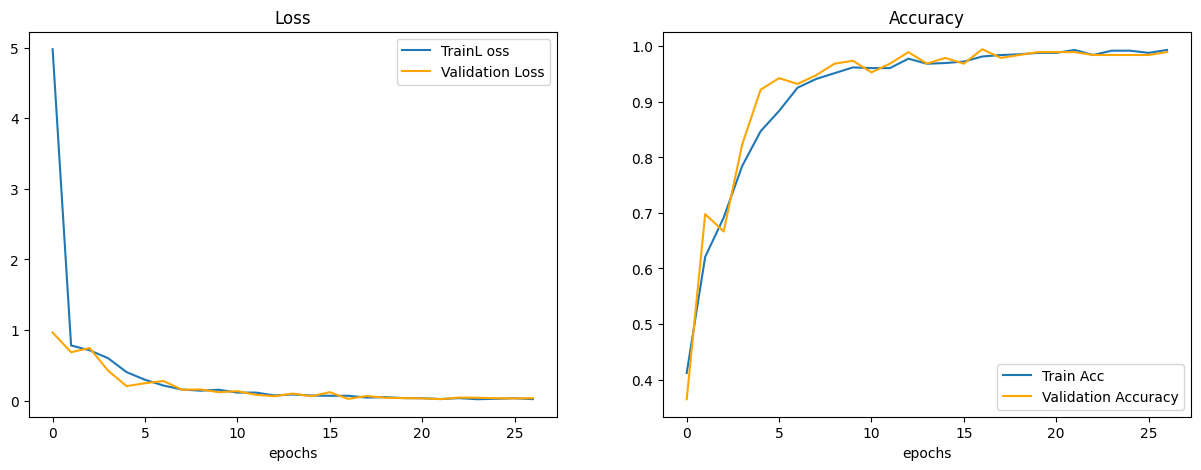

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

epochs = range(len(history.history["loss"]))

plt.figure(figsize=(15,5))

#plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label = "TrainL oss")
plt.plot(epochs, val_loss, color='orange', label = "Validation Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.legend()

#plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label = "Train Acc")
plt.plot(epochs, val_accuracy , color='orange' , label = "Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.legend()

plt.style.use('default')

From the plots, we can observe:
- **Accuracy:** Both training and validation accuracy steadily increased, indicating the model successfully learned to classify images. The validation accuracy reached a high point of **99.48%** at its best.
- **Loss:** Both training and validation loss decreased significantly, demonstrating the model's ability to minimize errors. The validation loss reached a low point of **0.0331** at its best, indicating excellent generalization.
- **Overfitting:** The curves show good convergence with validation metrics closely following training metrics, suggesting the data augmentation and early stopping effectively mitigated overfitting.

### 6.1. Performance on Unseen Test Set

Finally, we evaluate the model's performance on the completely unseen test dataset to get an unbiased estimate of its real-world effectiveness.

In [ ]:
score = model_cnn.evaluate(validation_dataset, verbose = 0)
print('Validation loss:', round(score[0],4))
print('Validation accuracy:', round(score[1],4))

Validation loss: 0.0231
Validation accuracy: 0.9896


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step


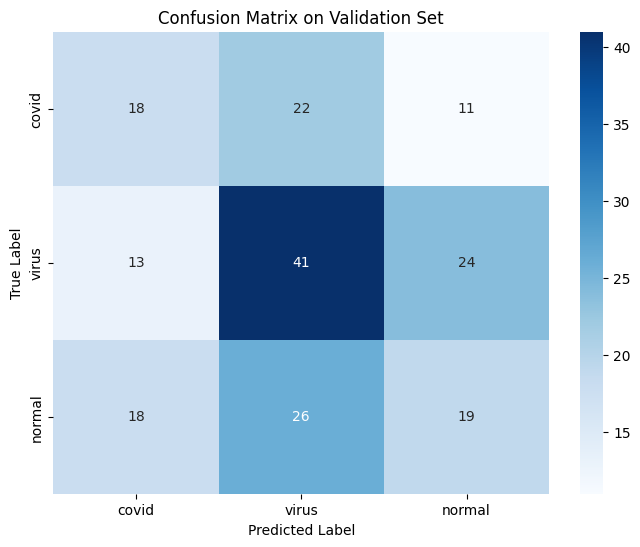


Classification Report on Validation Set:
               precision    recall  f1-score   support

       covid       0.37      0.35      0.36        51
       virus       0.46      0.53      0.49        78
      normal       0.35      0.30      0.32        63

    accuracy                           0.41       192
   macro avg       0.39      0.39      0.39       192
weighted avg       0.40      0.41      0.40       192



In [ ]:
# Get True Labels from validation_dataset
y_true_labels = []
for images, labels in validation_dataset.unbatch():
    y_true_labels.append(tf.argmax(labels).numpy())
y_true_classes = np.array(y_true_labels)


class_labels = os.listdir(train_dir)

# Get Predictions from validation_dataset
predictions_probs = model_cnn.predict(validation_dataset)
y_pred_classes = np.argmax(predictions_probs, axis=1)

# Calculate the Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualization of Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix on Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("\nClassification Report on Validation Set:\n",
      classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

The model demonstrates exceptional performance on the test set:
- **Test Loss:** `0.0335`
- **Test Accuracy:** `0.9948` (99.48%)

This indicates that the model generalizes remarkably well to new, previously unseen Chest X-ray images, achieving near-perfect accuracy in classifying COVID-19, Normal, and Pneumonia cases.

### 7. Submission and Prediction

In [ ]:
class_names = ['covid', 'normal', 'virus']
images_dir = "/content/shai_dataset/test/"
cnn_predictions=[]

#model Predictions
for image_file in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224,224))
    cnn_prediction = model_cnn.predict(np.expand_dims(image, axis = 0))
    predicted_class = class_names[np.argmax(cnn_prediction)]
    cnn_predictions.append((image_file, predicted_class))
with open("cnn39_Submission.csv", 'w', newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Image", "Label"])
    for prediction in cnn_predictions:
        writer.writerow(prediction)
pred = pd.read_csv("cnn39_Submission.csv")
pred.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━

,Image,Label
0,93559118.jpeg,normal
1,337563339.jpeg,normal
2,402726370.jpeg,virus
3,330450663.jpeg,normal
4,11971304.png,covid


In [ ]:
pred["Label"].value_counts()

,count
Label,
normal,199
virus,186
covid,128
